## Author: Dr. Manish Yadav

Duffing oscillator: 
d^2x/d^2t + c*dx/dt + k*x = f*sin(omega*t+phi)

conversion into 1st-order ordinary differential equation (state-space representation)

New set of variables:
    q1 = x
    q2 = dq1/dt = dx/dt

Transformation of ODE:
    dq1/dt = q2
    dq2/dt = -c*q2 -k*q1 +f*cos(omega*t+phi)

Notation in vector form:
    q = [q1, q2]^T
    F = [0, f*sin(omega*t+phi)]^T

    [dq/dt] = [[A]]*[q] + [F]

    state matrix A
    [[A]] = [[0, 1], [-k, -c]]

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import time
import pandas as pd

from scipy.integrate import odeint
from tqdm.notebook import tqdm, trange

In [116]:
def one_dof_oscillator(t, q: np.ndarray,
                       c: float = 0.1,
                       k: float = 1.0,
                       f: float = 0,
                       omega: float = 1.0,
                       phi: float = 0.0,
                       beta: float=0
                       ) -> np.ndarray:
    """ ODE one-dimensional oscillator. """

    A = np.array([[0, 1], [-k, -c]])
    B = np.array([[0, 0], [-beta, 0]])
    F = np.array([0, f*np.cos(omega*t+phi)])
    
    return np.dot(A, q) + np.dot(B, q*q*q) + F

def FreqGenerator(f, omega, t, phi):
    return np.array([0, f*np.cos(omega*t+phi)])

def SolveDuffing(q0, t_eval, c, k, f, omega, phi, beta):
    # numerical time integration
    sol_forced = solve_ivp(one_dof_oscillator, t_span=[t_eval[0], t_eval[-1]], y0=q0,\
                           t_eval=t_eval, args=(c, k, f, omega, phi, beta))

    # display of trajectories
    q = sol_forced.y.T
    t = sol_forced.t
    forcing = f*np.cos(omega*t+phi)  
    # Plot(q[:, 0], q[:, 1], forcing) 
    return q, forcing

def PhaseSpace_Plot(Q,f):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
    ax.plot(Q[500:,0], Q[500:,1], lw=1.0)
    plt.title('$f={:.2f}$'.format(f),fontsize=22)
    # plt.scatter(q[0,0], q[0,1], marker='o',c='r')
    ax.set_xlabel(r'$q_1(t)$',fontsize=22); ax.set_ylabel(r'$q_2(t)$',fontsize=22)
#     ax.set_xlim(-1.6,1.6); ax.set_ylim(-1.2,1.2)
    ax.tick_params(labelsize=18)
    plt.show()
    
#####Evaluation Metrics
def Signal_SqAmp(Dat, Trans):
    return np.max(Dat[Trans:]**2)

def Signal_SqMean(Dat, Trans):
    return np.mean(Dat[Trans:]**2)

def Signal_Characteristic(Dat, Trans):
    return np.array([[Signal_SqAmp(Dat, Trans)], [Signal_SqMean(Dat, Trans)]])

CPU times: total: 62.5 ms
Wall time: 90.4 ms
CPU times: total: 78.1 ms
Wall time: 74.8 ms


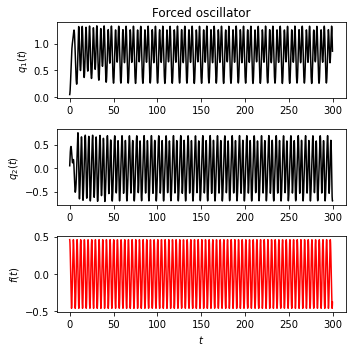

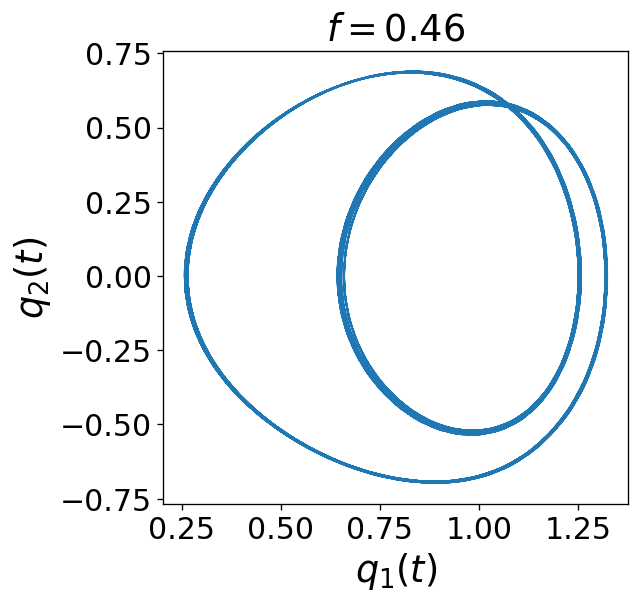

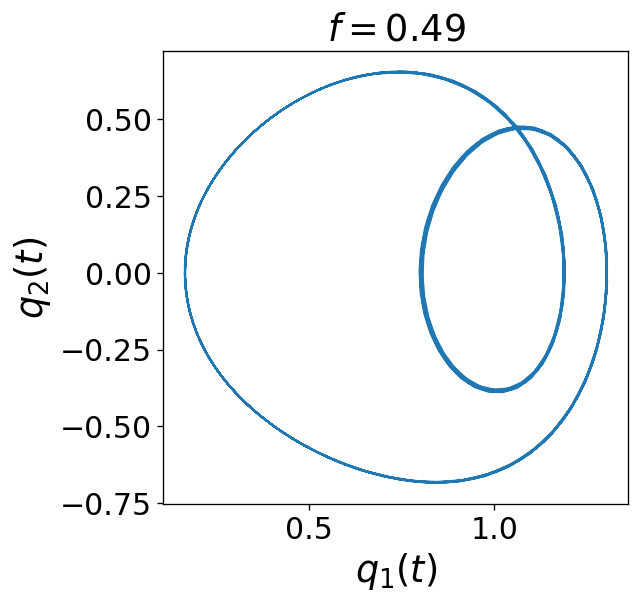

In [117]:
###Forced case: initial transient phase, then following forcing by some phase shift
###induced by the damping

######### Duffing Oscillator parameters####################################
c = 0.3    # damping
k = -1.0     # linear stiffness
fs = [0.46, 0.49]    # forced case
omega = 1.5
phi = 0
beta=1

# initial conditions
q0 = np.array([0.05, 0.05])

T = 300
t_eval = np.arange(start=0, stop=T, step=0.1)

# numerical time integration
# time integration interval
%time solA = solve_ivp(one_dof_oscillator, t_span=[t_eval[0], t_eval[-1]], y0=q0,\
                      t_eval=t_eval, args=(c, k, fs[0], omega, phi, beta))

%time solB = solve_ivp(one_dof_oscillator, t_span=[t_eval[0], t_eval[-1]], y0=q0,\
                      t_eval=t_eval, args=(c, k, fs[1], omega, phi, beta))

# display of trajectories
qa = solA.y.T; t_tr = solA.t
forcingA = fs[0]*np.cos(omega*t_tr+phi)

qb = solB.y.T;
forcingB = fs[1]*np.cos(omega*t_tr+phi)

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t_tr, qa[:, 0], color='black')
plt.ylabel(r'$q_1(t)$')
plt.title('Forced oscillator')

plt.subplot(3, 1, 2)
plt.plot(t_tr, qa[:, 1], color='black')
plt.ylabel(r'$q_2(t)$')

plt.subplot(3, 1, 3)
plt.plot(t_tr, forcingA, color='red')
plt.xlabel(r'$t$')
plt.ylabel(r'$f(t)$')
plt.tight_layout()
plt.show()
   
PhaseSpace_Plot(qa,fs[0])
PhaseSpace_Plot(qb,fs[1])

# Response analysis

In [124]:
def ForcingRespose(q0, t_eval, c, k, f_steps, omega, phi, beta, EvalTransients):
    # numerical time integration
    
    sol = solve_ivp(one_dof_oscillator, t_span=[t_eval[0], t_eval[-1]], y0=q0,\
                           t_eval=t_eval, args=(c, k, f_steps[0], omega, phi, beta))
    f_amp = np.repeat(f_steps[0], sol.t.shape[0])
    sols = sol.y; f_amps = f_amp; forcings = f_amp*np.cos(omega*t_eval+phi)
    TS_Char = Signal_Characteristic(sol.y[0], EvalTransients)
    ####Setting Initial condition for next forcing
    y0 = sol.y[:,-1]
    for i in trange(1,len(f_steps)):
        sol = solve_ivp(one_dof_oscillator, t_span=[t_eval[0], t_eval[-1]], y0=q0,\
                           t_eval=t_eval, args=(c, k, f_steps[i], omega, phi, beta))
        forcing = f_steps[i]*np.cos(omega*t_eval+phi)
        f_amp = np.repeat(f_steps[i], sol.t.shape[0])
        
        #####Arranging time-series##########
        sols=np.append(sols, sol.y, axis=1)
        forcings=np.append(forcings, forcing)
        f_amps=np.append(f_amps, f_amp)
        
        #####Characterizing time-series ####
        TS_Char1=Signal_Characteristic(sol.y[0], EvalTransients)
        TS_Char=np.append(TS_Char, TS_Char1, axis=1)
        
        ####Setting Initial condition for next forcing
        y0 = sol.y[:,-1]
    return sols, forcings, f_amps, TS_Char
    
def Plot(X, ts, f_amps, forcings, f_steps, TS_Char):
    # fig_size = plt.rcParams["figure.figsize"]  
    # fig_size[0] = 12; fig_size[1] = 8
    # plt.rcParams["figure.figsize"] = fig_size 
    # plt.figure()
    # plt.subplot(3, 1, 1)
    fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
    ax.plot(ts[::2], forcings[::2], lw=0.5, color='g')
    ax.set_ylabel(r'$f$', fontsize=30)
    ax.set_xlabel(r'$t$', fontsize=30)
    ax.set_xlim(ts[0]-2,ts[-1]+2)
    ax.tick_params(labelsize=20)
    plt.title('External Forcing', fontsize=22)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
    ax.plot(ts[::2], X[0,::2], lw=0.5, color='b')
    ax.set_ylabel(r'$q_1(t)$', fontsize=30)
    ax.set_xlabel(r'$t$', fontsize=30)
    ax.set_xlim(ts[0]-2,ts[-1]+2)
    ax.tick_params(labelsize=20)
    plt.title('Forced Duffing Oscillator', fontsize=22)
    plt.show()
    # plt.subplot(3, 1, 2)
    
    fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
    ax.plot(ts[::2], X[1,::2], lw=0.5, color='b')
    ax.set_xlim(ts[0]-2,ts[-1]+2)
    ax.set_ylabel(r'$q_2(t)$', fontsize=30)
    ax.set_xlabel(r'$t$', fontsize=30)
    ax.tick_params(labelsize=20)
    plt.show()
    
    # plt.subplot(3, 1, 3)
    fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
    ax.plot(ts[::2], f_amps[::2], lw=3, color='green', label='Test sets')
    ax.axhline(y = 0.46, c='grey', ls='--')
    ax.axhline(y = 0.49, c='grey', ls='--', label='Training sets')
    ax.legend(fontsize=18)
    ax.set_xlim(ts[0]-2,ts[-1]+2)
    ax.set_xlabel(r'$t$', fontsize=30)
    ax.set_ylabel(r'$f$ (amp)', fontsize=30)
    ax.tick_params(labelsize=20)
    # plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(5,5), dpi=150)
    plt.scatter(f_steps, TS_Char[0], marker='o',s=100,c='r')
    plt.xlabel(r'forcing steps', fontsize=25); plt.ylabel(r'Max($q_{1}^{2}$)', fontsize=25)
    ax.tick_params(labelsize=20)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(5,5), dpi=150) 
    plt.scatter(f_steps, TS_Char[1], marker='D',s=100,c='b')
    plt.xlabel(r'forcing steps', fontsize=25); plt.ylabel(r'Mean(${q_{1}^{2}}$)', fontsize=25)
    ax.tick_params(labelsize=20)
    plt.show()
    
    

  0%|          | 0/4 [00:00<?, ?it/s]

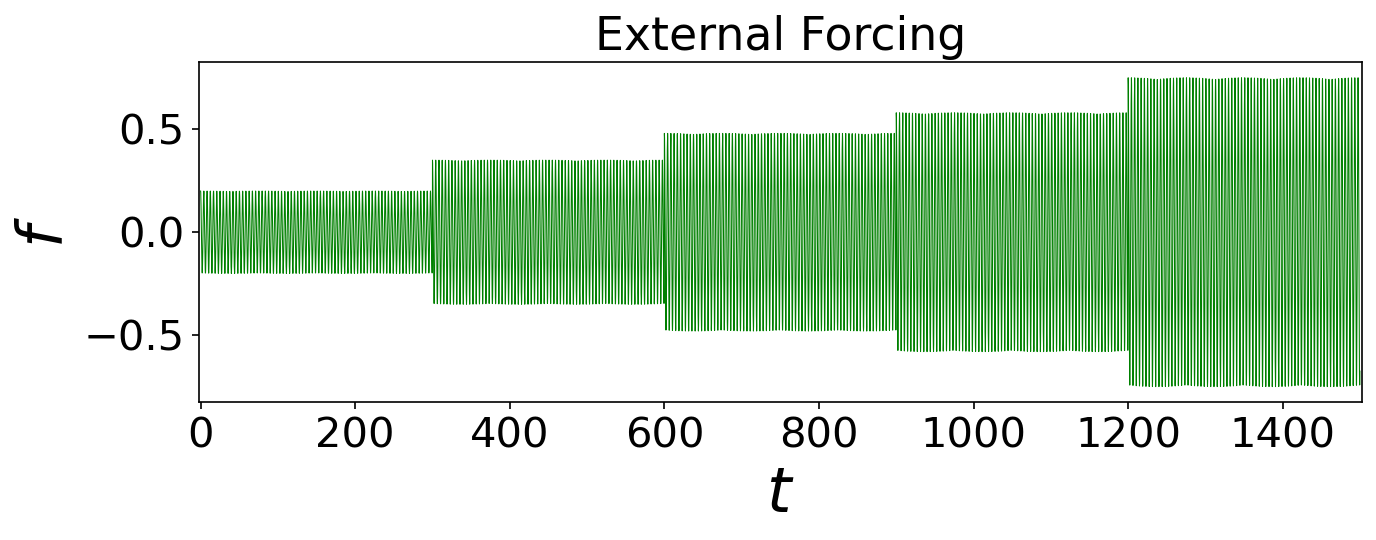

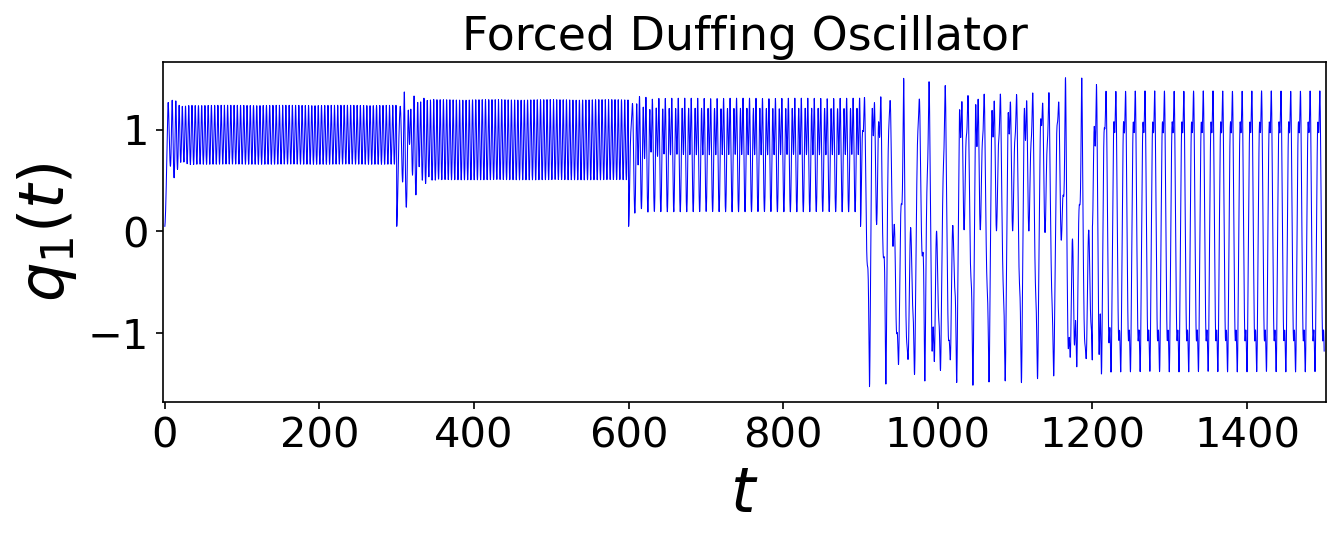

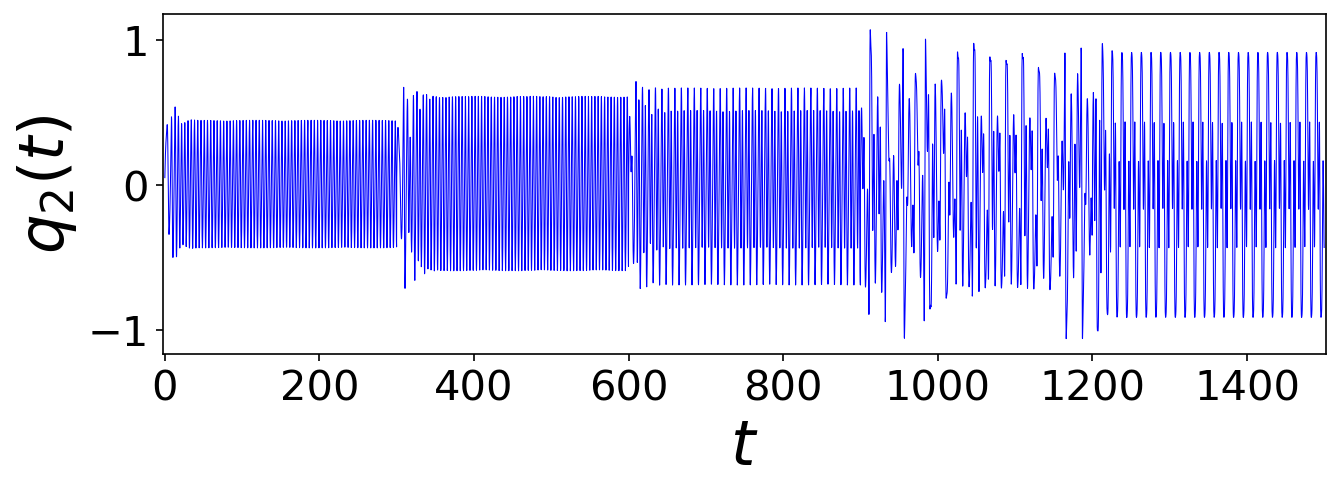

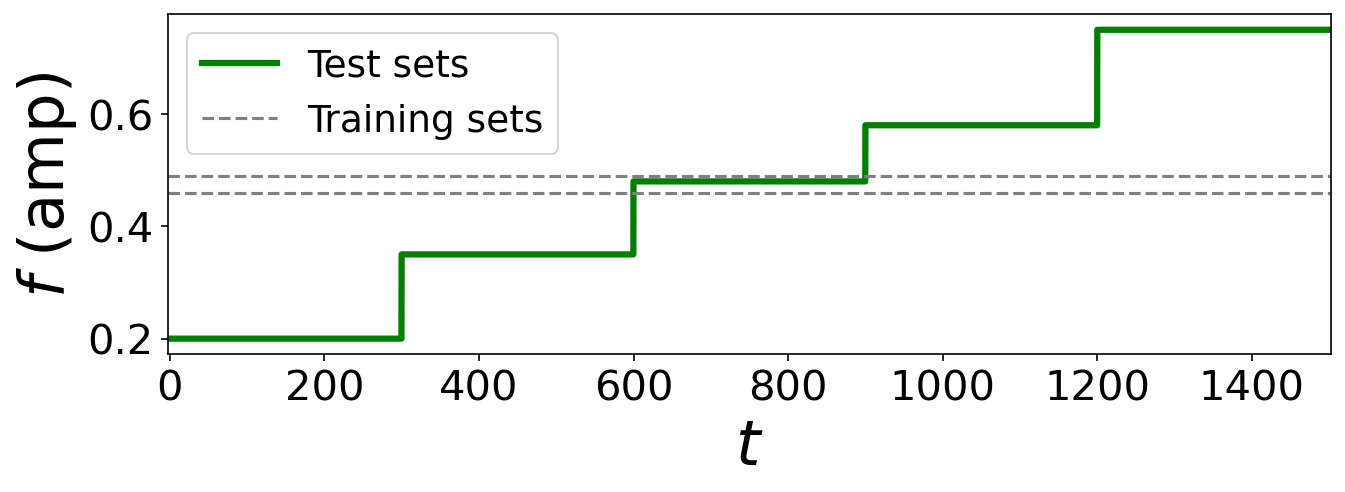

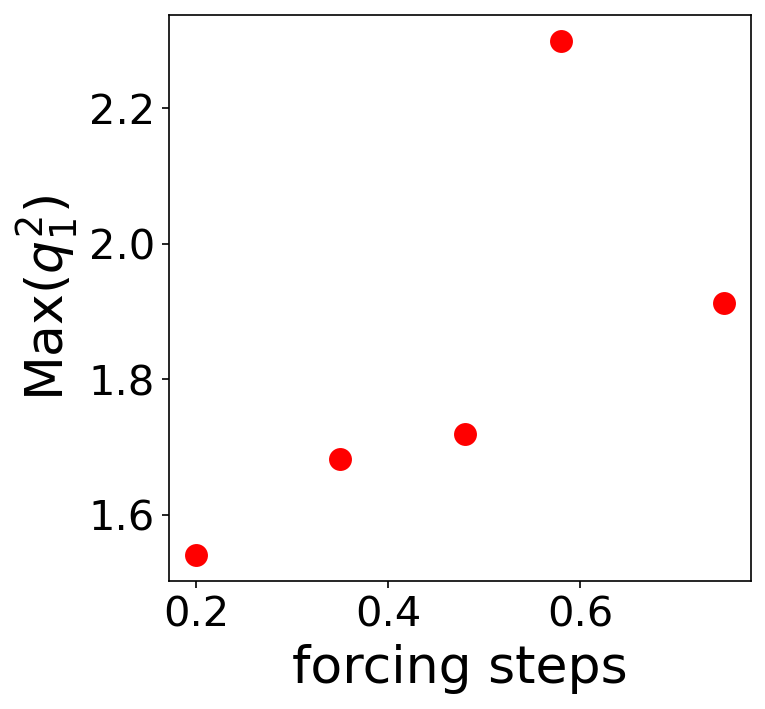

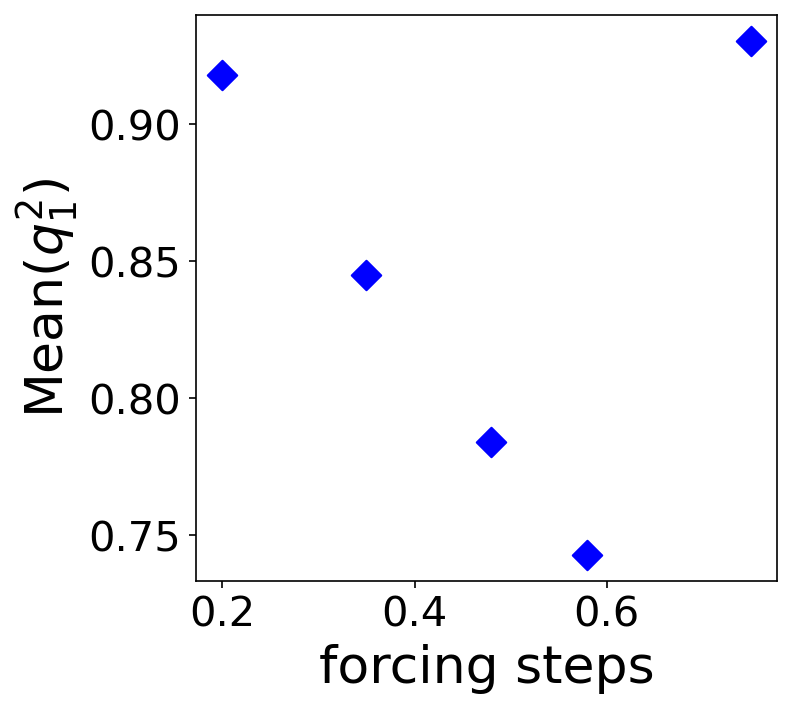

(2, 15000) (3000,) (15000,) (15000,)


In [125]:
T = 300; h=0.1
t_eval = np.arange(start=0, stop=T, step=0.1)

f_steps = [0.2, 0.35, 0.48, 0.58, 0.75]
EvalTransients=500

sols, forcings, f_amps, TS_Char =ForcingRespose(q0, t_eval, c, k, f_steps, omega, phi, beta, EvalTransients)
T_evals = np.arange(start=0, stop=T*len(f_steps), step=h)
Plot(sols, T_evals, f_amps, forcings, f_steps, TS_Char)

print(sols.shape, t_eval.shape, T_evals.shape, f_amps.shape)

# Save and Load Data

In [34]:
###### Prepare Data
## Train

Fs_a = np.tile(fs[0], qa.shape[0])
Tr_a = np.concatenate((np.expand_dims(t_tr,axis=1).T, qa.T), axis=0)
Tr_a = np.concatenate((Tr_a, np.expand_dims(forcingA, axis=1).T), axis=0)
Tr_a = np.concatenate((Tr_a, np.expand_dims(Fs_a, axis=1).T), axis=0)

Fs_b = np.tile(fs[1], qb.shape[0])
Tr_b = np.concatenate((np.expand_dims(t_tr,axis=1).T, qb.T), axis=0)
Tr_b = np.concatenate((Tr_b, np.expand_dims(forcingB, axis=1).T), axis=0)
Tr_b = np.concatenate((Tr_b, np.expand_dims(Fs_b, axis=1).T), axis=0)

Tr_Dat = np.concatenate((Tr_a, Tr_b), axis=1)
Tr_df = pd.DataFrame(Tr_Dat.T, columns=['time', 'qa(t)', 'qb(t)', 'f(t)', 'f_amplitude'])

## Test
Fs = np.repeat(f_steps, qa.shape[0])
Tst_Dat = np.concatenate((np.expand_dims(T_evals, axis=1).T, sols), axis=0)
Tst_Dat = np.concatenate((Tst_Dat, np.expand_dims(forcings, axis=1).T), axis=0)
Tst_Dat = np.concatenate((Tst_Dat, np.expand_dims(Fs, axis=1).T), axis=0)
Tst_df = pd.DataFrame(Tst_Dat.T, columns=['time', 'qa(t)', 'qb(t)', 'f(t)', 'f_amplitude'])
print(Tr_df, Tst_df)
print(Tr_Dat.shape, Tst_Dat.shape)

       time     qa(t)     qb(t)      f(t)  f_amplitude
0       0.0  0.050000  0.050000  0.460000         0.46
1       0.1  0.057455  0.098909  0.454835         0.46
2       0.2  0.069723  0.146335  0.439455         0.46
3       0.3  0.086633  0.191770  0.414206         0.46
4       0.4  0.107971  0.234741  0.379654         0.46
...     ...       ...       ...       ...          ...
5995  299.5  1.017666 -0.641789 -0.489999         0.49
5996  299.6  0.952073 -0.668122 -0.484332         0.49
5997  299.7  0.884506 -0.681190 -0.467788         0.49
5998  299.8  0.816204 -0.682528 -0.440738         0.49
5999  299.9  0.748278 -0.673993 -0.403791         0.49

[6000 rows x 5 columns]          time     qa(t)     qb(t)      f(t)  f_amplitude
0         0.0  0.050000  0.050000  0.200000         0.20
1         0.1  0.056170  0.073349  0.197754         0.20
2         0.2  0.064651  0.096297  0.191067         0.20
3         0.3  0.075391  0.118633  0.180089         0.20
4         0.4  0.088325  0.140

In [37]:
####Save data
# Tr_df.to_csv('DORA_Train.csv', index=False)
# Tst_df.to_csv('DORA_Test.csv', index=False)

In [126]:
#### Load data

DORA_Tr1 = pd.read_csv('DORA_Train.csv').to_numpy().T
DORA_Tst1 = pd.read_csv('DORA_Test.csv').to_numpy().T

print(DORA_Tr1.shape, DORA_Tst1.shape)

(5, 6000) (5, 15000)


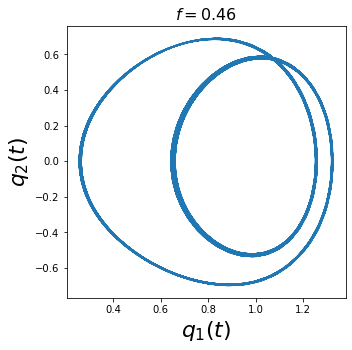

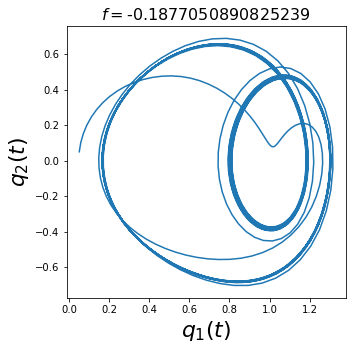

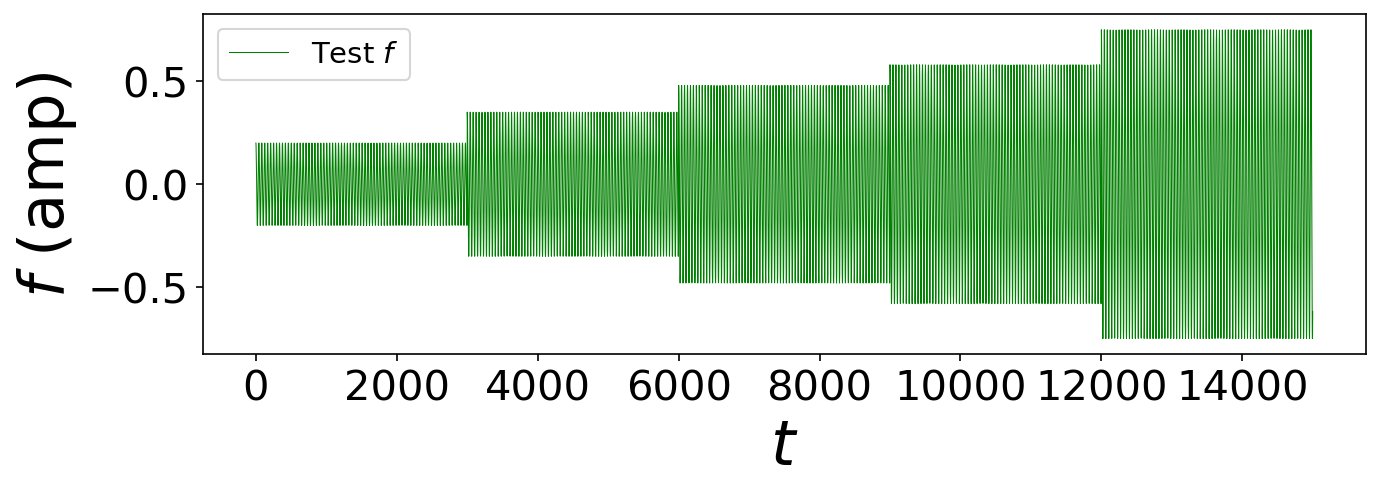

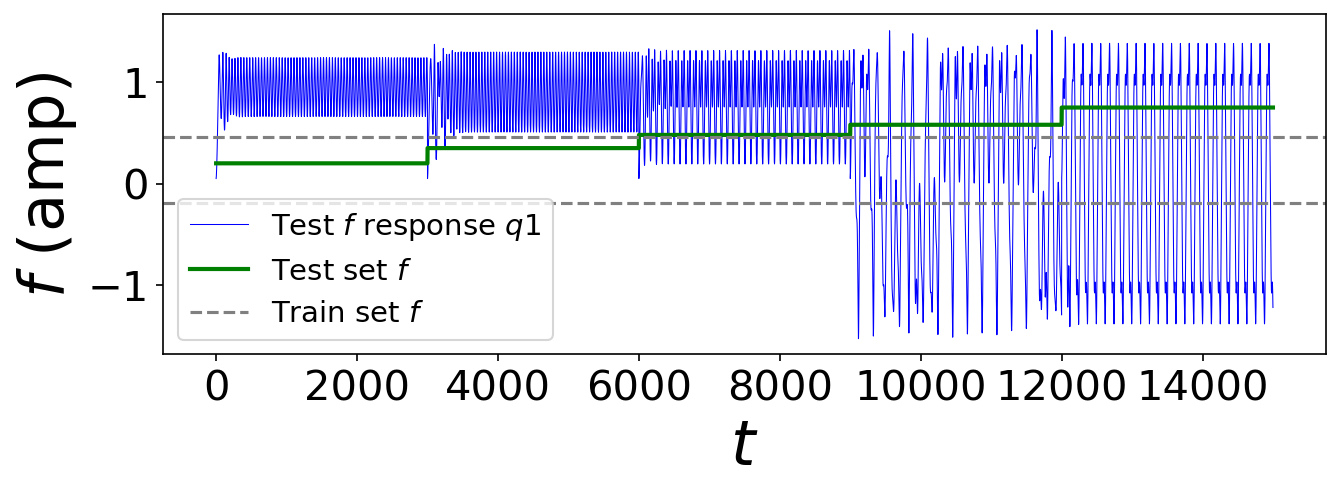

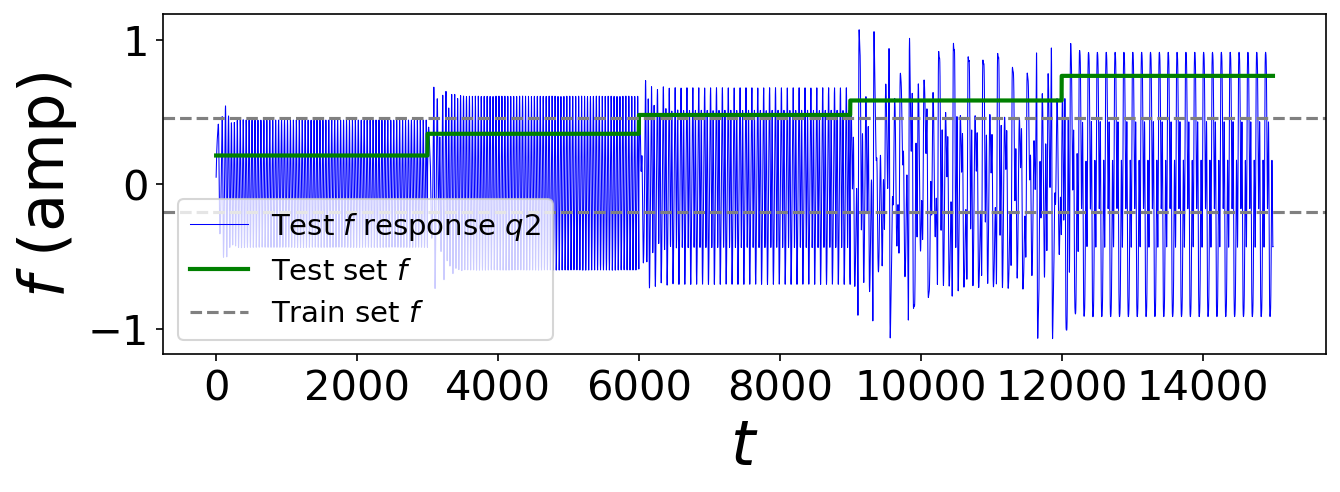

In [127]:
#### Plot loaded data
T=2500

fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 5; fig_size[1] = 5
    
plt.plot(DORA_Tr1[1,500:T], DORA_Tr1[2,500:T])
plt.title('$f=${:}'.format(DORA_Tr1[3,0]), fontsize=16)
plt.xlabel(r'$q_1(t)$',fontsize=22); plt.ylabel(r'$q_2(t)$',fontsize=22)
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(DORA_Tr1[1,T+500:], DORA_Tr1[2,T+500:])
plt.title('$f=${:}'.format(DORA_Tr1[3,T]), fontsize=16)
plt.xlabel(r'$q_1(t)$',fontsize=22); plt.ylabel(r'$q_2(t)$',fontsize=22)
plt.show()


fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(DORA_Tst1[3], lw=0.5, color='g', label='Test $f$')
ax.legend(fontsize=14)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylabel(r'$f$ (amp)', fontsize=30)
ax.tick_params(labelsize=20)
# plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(DORA_Tst1[1,::1], lw=0.5, color='b', label='Test $f$ response $q1$')
ax.plot(DORA_Tst1[4], lw=2, color='green', label='Test set $f$')
ax.axhline(y = DORA_Tr1[3,0], c='grey', ls='--')
ax.axhline(y = DORA_Tr1[3,T], c='grey', ls='--', label='Train set $f$')
ax.legend(fontsize=14)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylabel(r'$f$ (amp)', fontsize=30)
ax.tick_params(labelsize=20)
# plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(DORA_Tst1[2,::1], lw=0.5, color='b', label='Test $f$ response $q2$')
ax.plot(DORA_Tst1[4], lw=2, color='green', label='Test set $f$')
ax.axhline(y = DORA_Tr1[3,0], c='grey', ls='--')
ax.axhline(y = DORA_Tr1[3,T], c='grey', ls='--', label='Train set $f$')
ax.legend(fontsize=14)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylabel(r'$f$ (amp)', fontsize=30)
ax.tick_params(labelsize=20)
# plt.tight_layout()
plt.show()